In [9]:
!pip install transformers datasets scikit-learn pandas wordcloud xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\HADEZZZ\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\HADEZZZ\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
!pip install nltk textblob




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\HADEZZZ\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import torch
print(torch.version.cuda)  # Should print "11.8"
print(torch.backends.cudnn.is_available()) 
print(torch.cuda.is_available()) 
# print(torch.cuda.get_device_name(0)) 

11.8
True
True


In [2]:
from datasets import load_dataset

# Load SST5 dataset
sst5_dataset = load_dataset("SetFit/sst5")
train_data = sst5_dataset["train"]
train_data[0]

C:\Users\HADEZZZ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.


{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films',
 'label': 4,
 'label_text': 'very positive'}

In [4]:
twitter_dataset = load_dataset("tweet_eval", "sentiment")
twt_train_data = twitter_dataset["train"]
twt_train_data[0]

{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 'label': 2}

In [5]:
print(sst5_dataset)
print(sst5_dataset["train"].column_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})
['text', 'label', 'label_text']


In [6]:
print(twitter_dataset)
print(twitter_dataset["train"].column_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
['text', 'label']


In [7]:
def convert_sst5(example):
    label = int(example["label"])
    # label = example["label"]
    if label in [0, 1]:
        return {"text": example["text"], "label": 0}
    elif label == 2:
        return {"text": example["text"], "label": 1}
    else:
        return {"text": example["text"], "label": 2}

# sst5_mapped = sst5_dataset.map(convert_sst5)
sst5_mapped = sst5_dataset.map(convert_sst5, remove_columns=["label_text"])
print(sst5_mapped["train"][0])
print(sst5_dataset["train"][0])


{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 2}
{'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 4, 'label_text': 'very positive'}


In [8]:
from datasets import DatasetDict, Value

def convert_twitter(example):
    return {"text": example["text"], "label": int(example["label"])}


twitter_mapped = twitter_dataset.map(convert_twitter)
print(twitter_mapped["train"][0])

# Force label column to be int64 instead of ClassLabel

# twitter_mapped = DatasetDict({
#     split: ds.cast_column("label", Value("int64"))
#     for split, ds in twitter_dataset.items()
# })


{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}


In [9]:
from datasets import concatenate_datasets, DatasetDict
from datasets import ClassLabel

# Define common ClassLabel
label_class = ClassLabel(names=["negative", "neutral", "positive"])

# Ensure label columns are the same type before combining
sst5_mapped = sst5_mapped.cast_column("label", label_class)
twitter_mapped = twitter_mapped.cast_column("label", label_class)

full_combined_dataset = concatenate_datasets([
    sst5_mapped["train"], 
    sst5_mapped["test"], 
    twitter_mapped["train"], 
    twitter_mapped["test"],
    sst5_mapped["validation"], 
    twitter_mapped["validation"]
    
])

# Shuffled
full_combined_dataset = full_combined_dataset.shuffle(seed=42)
print(full_combined_dataset)


Dataset({
    features: ['text', 'label'],
    num_rows: 71754
})


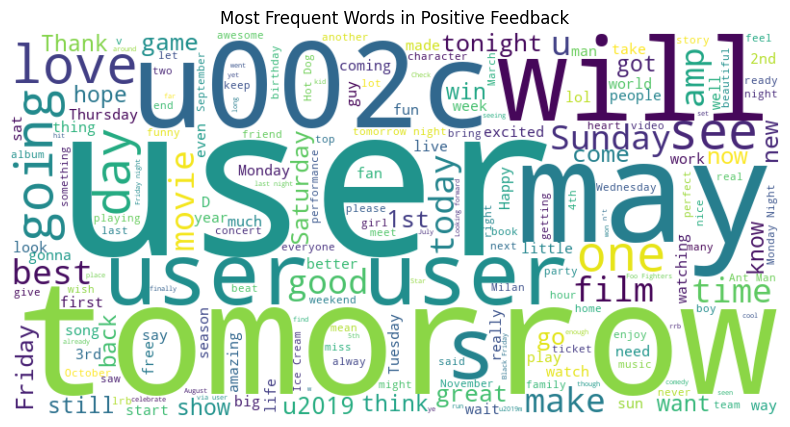

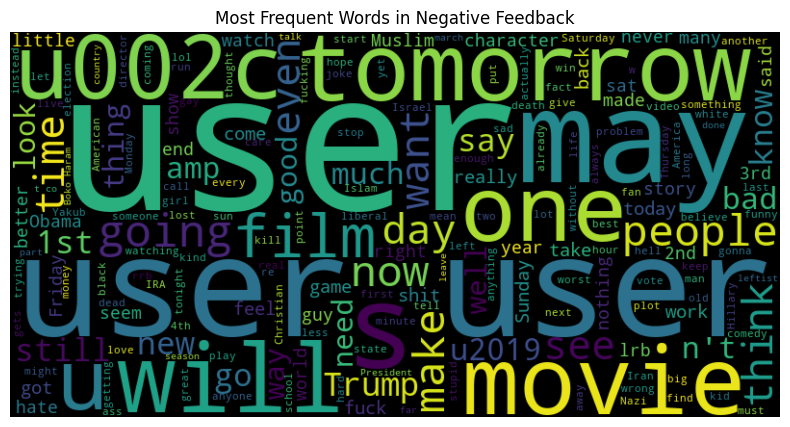

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get positive and negative texts using .filter()
positive_examples = full_combined_dataset.filter(lambda x: x["label"] == 2)
negative_examples = full_combined_dataset.filter(lambda x: x["label"] == 0)

# Join all texts into a single string
positive_texts = " ".join(positive_examples["text"])
negative_texts = " ".join(negative_examples["text"])

# WordCloud for positive feedback
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Feedback")
plt.show()

# WordCloud for negative feedback
wordcloud_neg = WordCloud(width=800, height=400, background_color="black").generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Feedback")
plt.show()


In [13]:
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from textblob import TextBlob

nltk.download('punkt')
nltk.download('stopwords')

# Convert to lowercase, remove punctuation, and tokenize
def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text.translate(str.maketrans("", "", string.punctuation)))
    return [word for word in tokens if word not in stopwords.words("english")]

# Get word frequencies
positive_words = []
negative_words = []

for entry in full_combined_dataset:
    tokens = preprocess(entry["text"])
    if entry["label"] == 2:
        positive_words.extend(tokens)
    elif entry["label"] == 0:
        negative_words.extend(tokens)

# Count word frequencies
pos_counter = Counter(positive_words)
neg_counter = Counter(negative_words)

# Get domain-specific common words
common_words = set(pos_counter) & set(neg_counter)
domain_stopwords = {word for word in common_words if pos_counter[word] > 5 and neg_counter[word] > 5}


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HADEZZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HADEZZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def remove_domain_stopwords(text):
    tokens = preprocess(text)
    filtered_tokens = [word for word in tokens if word not in domain_stopwords]
    return " ".join(filtered_tokens)

# Apply the function to your dataset
# for entry in full_combined_dataset:
#     entry["text"] = remove_domain_stopwords(entry["text"])
 
full_combined_dataset = full_combined_dataset.map(lambda x: {"text": remove_domain_stopwords(x["text"])})
print(full_combined_dataset[0])


Map: 100%|██████████| 71754/71754 [01:26<00:00, 830.01 examples/s]

{'text': 'charlotte triple', 'label': 1, 'clean_text': 'charlotte triple', 'polarity': 0.0, 'word_count': 2, 'pos_word_count': 0, 'neg_word_count': 0}


In [15]:
import nltk
from nltk.corpus import opinion_lexicon

nltk.download('opinion_lexicon')

pos_lexicon = set(opinion_lexicon.positive())
neg_lexicon = set(opinion_lexicon.negative())

def extract_features(example):
    tokens = preprocess(example["text"])
    filtered_tokens = [t for t in tokens if t not in domain_stopwords]
    
    text_blob = TextBlob(" ".join(filtered_tokens))
    polarity = text_blob.sentiment.polarity
    
    pos_count = sum(1 for word in filtered_tokens if word in pos_lexicon)
    neg_count = sum(1 for word in filtered_tokens if word in neg_lexicon)
    
    return {
        "clean_text": " ".join(filtered_tokens),
        "polarity": polarity,
        "word_count": len(filtered_tokens),
        "pos_word_count": pos_count,
        "neg_word_count": neg_count,
    }


# Apply feature extraction
# for entry in full_combined_dataset:
#     features = extract_features(entry["text"])
#     entry.update(features)

full_combined_dataset = full_combined_dataset.map(extract_features)
print(full_combined_dataset[0])


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\HADEZZZ\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
Map: 100%|██████████| 71754/71754 [08:41<00:00, 137.56 examples/s]

{'text': '"Charlotte, The New Day, Triple H, John Cena and others sit down with Michael Cole every Wednesday in', 'label': 1, 'clean_text': 'charlotte triple', 'polarity': 0.0, 'word_count': 2, 'pos_word_count': 0, 'neg_word_count': 0}


In [16]:
# Split the combined dataset (80% train, 20% test)
combined_dataset = full_combined_dataset.train_test_split(
    test_size=0.2,
    stratify_by_column="label"  # makes sure all labels are balanced
)

combined_train = combined_dataset["train"]
combined_test = combined_dataset["test"]

In [17]:
import re
import string

def clean_text(combined_train):
    combined_train = combined_train.lower()
    combined_train = re.sub(r"http\S+|www\S+|https\S+", '', combined_train, flags=re.MULTILINE)  # Remove URLs
    combined_train = re.sub(r'\@\w+|\#', '', combined_train)  # Remove @mentions and hashtags
    combined_train = combined_train.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    combined_train = re.sub(r'\d+', '', combined_train)  # Remove digits
    combined_train = re.sub(r'\s+', ' ', combined_train).strip()  # Remove extra whitespaces
    return combined_train

combined_train = combined_train.map(lambda x: {"text": clean_text(x["text"])})
combined_test = combined_test.map(lambda x: {"text": clean_text(x["text"])})

Map: 100%|██████████| 14351/14351 [00:01<00:00, 9018.34 examples/s]


In [18]:
from collections import Counter

label_counts = Counter(combined_train['label'])
print(label_counts)


Counter({1: 23777, 2: 20805, 0: 12821})


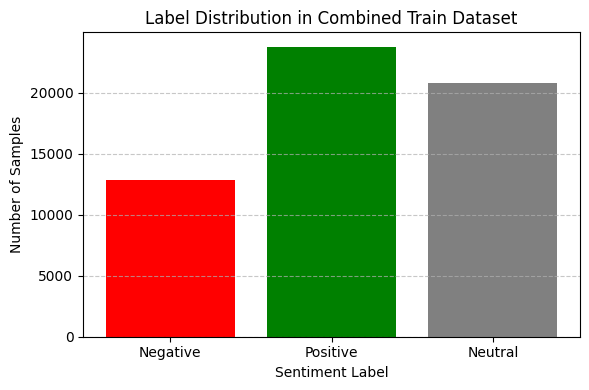

In [19]:
# Count the number of each label
# label_counts = Counter(combined_train['label'])

# Convert keys and values to lists for plotting
labels = list(label_counts.keys())
counts = list(label_counts.values())

# names for readability
label_names = ['Neutral', 'Positive', 'Negative']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, tick_label=label_names, color=['gray', 'green', 'red'])
plt.title("Label Distribution in Combined Train Dataset")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [20]:
label_counts_test = Counter(combined_test['label'])
print(label_counts_test)


Counter({1: 5944, 2: 5201, 0: 3206})


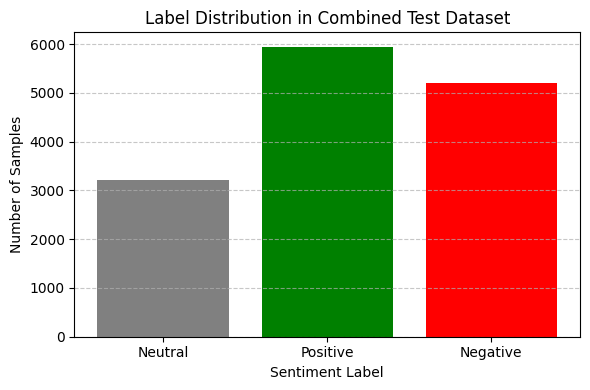

In [21]:
# Count the number of each label
# label_counts = Counter(combined_train['label'])

# Convert keys and values to lists for plotting
labels_test = list(label_counts_test.keys())
counts_test = list(label_counts_test.values())

# names for readability
label_names_test = ['Positive', 'Neutral', 'Negative']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels_test, counts_test, tick_label=label_names_test , color=['green', 'gray', 'red'])

# plt.bar(labels_test, counts_test, tick_label=label_names, color=['red', 'green', 'gray'])
plt.title("Label Distribution in Combined Test Dataset")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Filter:   0%|          | 0/71754 [00:00<?, ? examples/s]

Filter: 100%|██████████| 71754/71754 [00:00<00:00, 166288.42 examples/s]


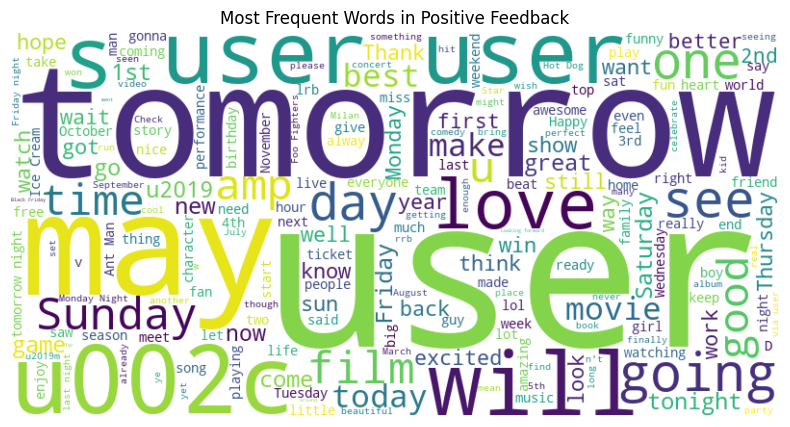

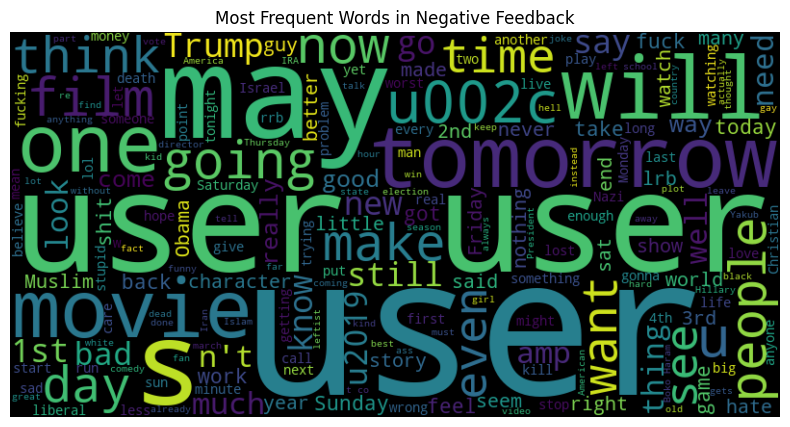

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get positive and negative texts using .filter()
positive_examples = full_combined_dataset.filter(lambda x: x["label"] == 2)
negative_examples = full_combined_dataset.filter(lambda x: x["label"] == 0)

# Join all texts into a single string
positive_texts = " ".join(positive_examples["text"])
negative_texts = " ".join(negative_examples["text"])

# WordCloud for positive feedback
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Feedback")
plt.show()

# WordCloud for negative feedback
wordcloud_neg = WordCloud(width=800, height=400, background_color="black").generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Feedback")
plt.show()


In [23]:
import torch

In [24]:
full_combined_dataset.column_names

['text',
 'label',
 'clean_text',
 'polarity',
 'word_count',
 'pos_word_count',
 'neg_word_count']

In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Class labels
class_labels = [0, 1, 2]

# Corresponding labels from your dataset (flattened list of all labels)
# Assuming `all_labels` is your list or array of all labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(class_labels),
    y=combined_train['label']  # Replace with your full label list
)

print(class_labels, class_weights)

[0, 1, 2] [1.49242129 0.80474128 0.91969879]


In [49]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Shows your GPU name


True
NVIDIA GeForce RTX 4060 Laptop GPU


In [26]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification

# Defining weights from earlier 
weights = torch.tensor(class_weights, dtype=torch.float)

class WeightedLossDistilBERT(BertForSequenceClassification):
    def __init__(self, config, weight):
        super().__init__(config)
        self.weight = weight

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        output = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=None)
        logits = output.logits
        loss_fn = nn.CrossEntropyLoss(weight=self.weight.to(logits.device))
        loss = loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}


In [ ]:
from transformers import AutoConfig
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

model_checkpoint = "bert-base-uncased"
config = AutoConfig.from_pretrained(model_checkpoint, num_labels=3)
model = WeightedLossDistilBERT.from_pretrained(model_checkpoint, config=config, weight=weights)
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets_train = combined_train.map(tokenize_function, batched=True)
tokenized_datasets_test = combined_test.map(tokenize_function, batched=True)
print(tokenized_datasets_train[0])
tokenized_datasets_train.set_format("torch", columns=["clean_text","input_ids", "attention_mask", "label"])
tokenized_datasets_test.set_format("torch", columns=["clean_text","input_ids", "attention_mask", "label"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


training_args = TrainingArguments(
    output_dir="./bert-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_steps=500,
    logging_dir="./logs",
    logging_steps=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,  # <--- Enable if your GPU supports it (mixed precision)
    seed=42,    
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer1 = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer1.train()

# 9. Evaluate
metrics = trainer1.evaluate()
print(metrics)

# Get BERT logits for evaluation set
bert_outputs = trainer1.predict(tokenized_datasets_test)
bert_logits = bert_outputs.predictions
bert_probs = torch.nn.functional.softmax(torch.tensor(bert_logits), dim=-1).numpy()

Some weights of WeightedLossDistilBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: NVIDIA GeForce RTX 4060 Laptop GPU


Map: 100%|██████████| 14351/14351 [00:05<00:00, 2673.66 examples/s]
C:\Users\HADEZZZ\AppData\Local\Temp\ipykernel_22348\41318032.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(


{'text': 'i met camila back in april my dna on her hands i love hanging out with niall', 'label': 2, 'clean_text': 'dna', 'polarity': 0.0, 'word_count': 1, 'pos_word_count': 0, 'neg_word_count': 0, 'input_ids': [101, 1045, 2777, 11503, 11733, 2067, 1999, 2258, 2026, 6064, 2006, 2014, 2398, 1045, 2293, 5689, 2041, 2007, 21889, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Using device: NVIDIA GeForce RTX 4060 Laptop GPU


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.624900,0.632073,0.713469,0.724340,0.713469,0.714085
2,0.561300,0.666646,0.720995,0.724992,0.720995,0.717494
3,0.315300,0.780880,0.722110,0.721281,0.722110,0.721052
4,0.187400,1.037220,0.717372,0.716901,0.717372,0.717090


{'eval_loss': 0.7808796763420105, 'eval_accuracy': 0.7221099574942512, 'eval_precision': 0.7212810156177578, 'eval_recall': 0.7221099574942512, 'eval_f1': 0.7210522622232597, 'eval_runtime': 19.2809, 'eval_samples_per_second': 744.311, 'eval_steps_per_second': 46.523, 'epoch': 4.0}


In [28]:
# Extract handcrafted features from raw eval set
print(combined_test[0])
augmented_dataset = combined_test.map(extract_features)
print(augmented_dataset[0])
handcrafted_features = [
    [entry["polarity"], entry["word_count"], entry["pos_word_count"], entry["neg_word_count"]]
    for entry in augmented_dataset  # original (non-tokenized) test split
]
handcrafted_features = np.array(handcrafted_features)


{'text': 'follow the top iran stories for dec on our topical page', 'label': 1, 'clean_text': 'topical', 'polarity': 0.0, 'word_count': 1, 'pos_word_count': 0, 'neg_word_count': 0}


Map: 100%|██████████| 14351/14351 [01:39<00:00, 144.65 examples/s]


{'text': 'follow the top iran stories for dec on our topical page', 'label': 1, 'clean_text': 'topical', 'polarity': 0.0, 'word_count': 1, 'pos_word_count': 0, 'neg_word_count': 0}


In [29]:
# Combine BERT + custom features
X_combined = np.concatenate([bert_probs, handcrafted_features], axis=1)
y_true = np.array([entry["label"] for entry in combined_test])


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split to avoid overfitting on test
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_true, test_size=0.3, stratify=y_true)

# Train logistic regression
meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_train, y_train)

# Evaluate
y_pred = meta_clf.predict(X_val)
print("=== Meta-Classifier Evaluation ===")
print(classification_report(y_val, y_pred))


=== Meta-Classifier Evaluation ===
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       962
           1       0.70      0.69      0.69      1783
           2       0.77      0.78      0.77      1561

    accuracy                           0.73      4306
   macro avg       0.73      0.73      0.73      4306
weighted avg       0.73      0.73      0.73      4306

